In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fooof.sim import gen_power_spectrum
from fooof import FOOOF
from specparam import SpecParam

## Simulate

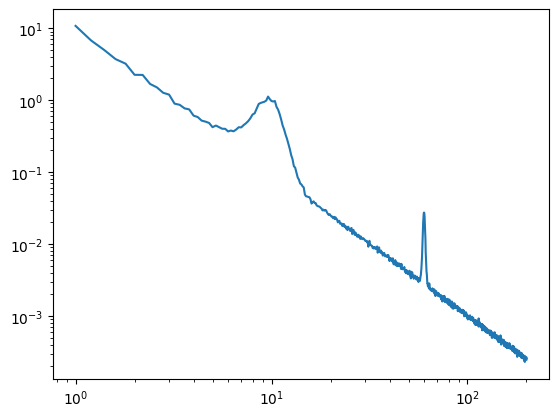

In [2]:
np.random.seed(1)
freqs, powers = gen_power_spectrum((1, 200), (1, 2), [[10, 1, 2], [60, 1, 1]], nlv=.02, freq_res=.2)
plt.loglog(freqs, powers);

## Rust Implementation

In [3]:
%%timeit
sp = SpecParam(max_n_peaks=5, aperiodic_mode='linear')
res = sp.fit(freqs, powers)

3.95 ms ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Python Implementation

In [4]:
%%timeit
fm = FOOOF(max_n_peaks=5, aperiodic_mode='fixed', verbose=False)
fm.fit(freqs, powers)

3.05 s ± 287 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Goodness of Fit

In [5]:
sp = SpecParam(max_n_peaks=5, aperiodic_mode='linear')
res = sp.fit(freqs, powers)
res.peak_params_

array([[10.03155051,  0.98940847,  2.74632103],
       [60.00338518,  1.00230863,  1.41487256]])

In [6]:
fm = FOOOF(max_n_peaks=2, aperiodic_mode='knee', verbose=False)
fm.fit(freqs, powers)
fm.peak_params_

array([[10.03125415,  0.97998449,  3.83109589],
       [60.00352585,  1.00125979,  1.9978297 ]])

In [7]:
print(f'R^2 Rust  : {np.corrcoef(np.log10(powers), res.powers_log_fit)[0][1] ** 2}')
print(f'R^2 Python: {np.corrcoef(np.log10(powers), fm.fooofed_spectrum_)[0][1] ** 2}')

R^2 Rust  : 0.9994869523539566
R^2 Python: 0.9994651129207979


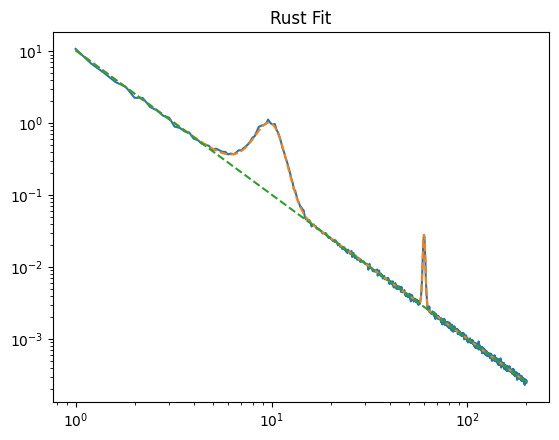

In [8]:
plt.title('Rust Fit')
plt.loglog(freqs, powers)
plt.loglog(freqs, 10**res.powers_log_fit, ls='--')
plt.loglog(freqs, 10**res._ap_fit, ls='--');

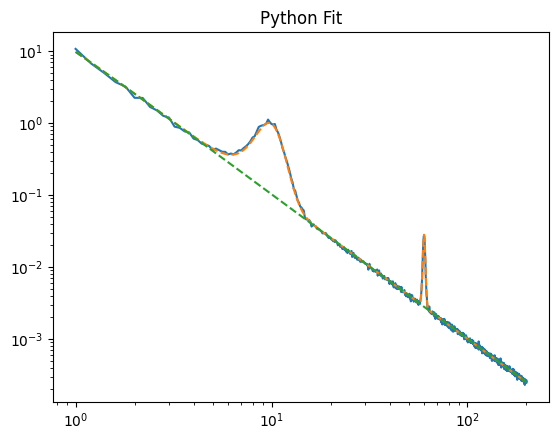

In [9]:
plt.title('Python Fit')
plt.loglog(freqs, powers)
plt.loglog(freqs, 10**fm.fooofed_spectrum_, ls='--')
plt.loglog(freqs, 10**fm._ap_fit, ls='--');